In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import corner
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from astroML.utils import completeness_contamination
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [2]:
data = pd.read_csv("C:/Users/leoni/Desktop/astrostatistics_bicocca_2024/solutions/galaxyquasar.csv")

In [3]:
le = LabelEncoder()

data['class'] = le.fit_transform(data['class'])
labels = le.inverse_transform(data['class'])
class_names = le.classes_
#così adesso i QSO hanno label=1 e gal hanno label=0

In [4]:
class_names

array(['GALAXY', 'QSO'], dtype=object)

In [5]:
data

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,1,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,0,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,0,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,0,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,1,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,0,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,0,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,0,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,0,0.112571,0.000009


In [6]:
rows_with_nan = data[data.isnull().any(axis=1)]
print(rows_with_nan)
#non ci sono Nan

Empty DataFrame
Columns: [u, g, r, i, z, class, z1, zerr]
Index: []


In [7]:
u=data['u']
g=data['g']
r=data['r']
i=data['i']
z=data['z']
labels=data['class']

u=np.array(u)
g=np.array(g)
r=np.array(r)
i=np.array(i)
z=np.array(z)
labels=np.array(labels)

u_g=u-g
g_r=g-r
r_i=r-i
i_z=i-z

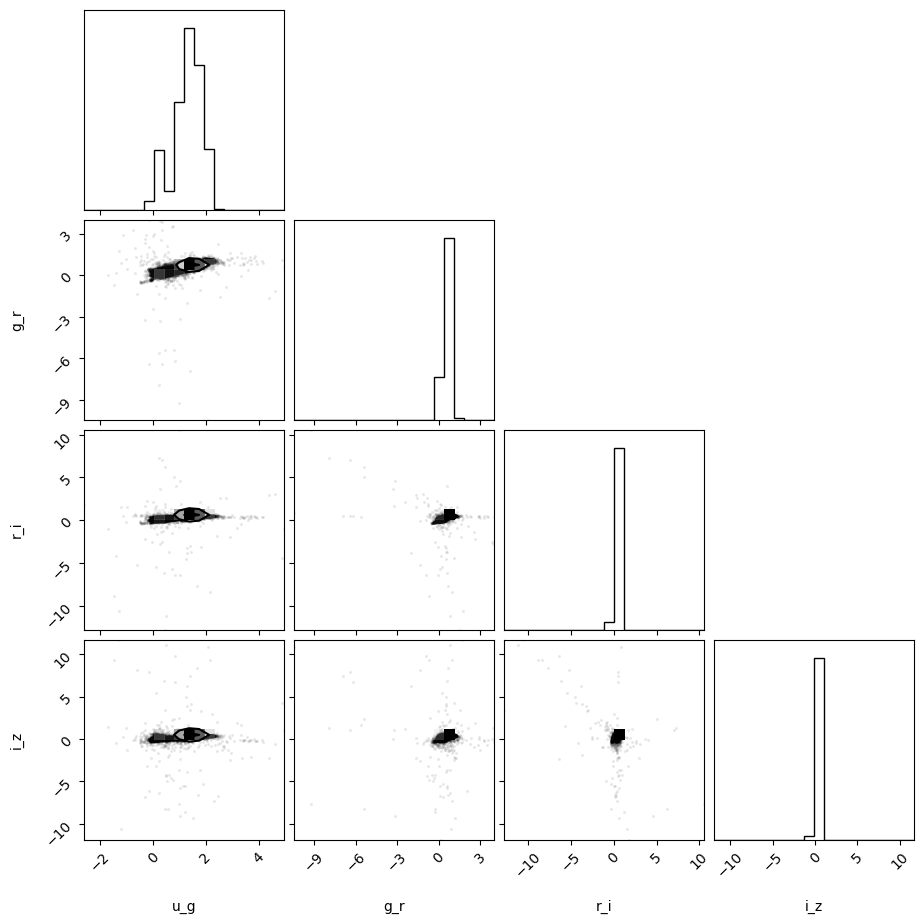

In [8]:
colori=np.column_stack((u_g, g_r, r_i,i_z))

nomi = ["u_g","g_r", "r_i", "i_z"]

fig = corner.corner(colori, labels=nomi)

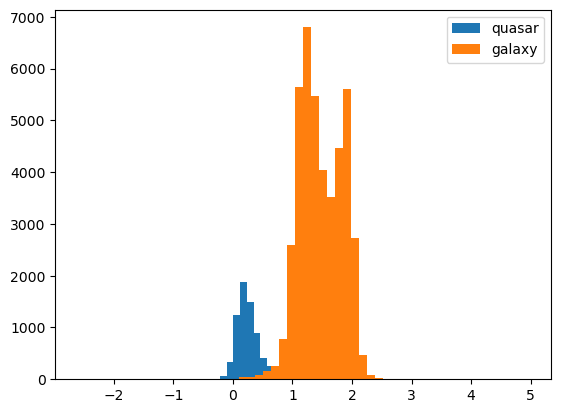

In [9]:
u_gQSO=u_g[labels==1]
u_gGAL=u_g[labels==0]
plt.hist(u_gQSO, bins=50, label="quasar")
plt.hist(u_gGAL, bins=50, label="galaxy")
plt.legend()
plt.show()

#quindi probabilmente la dimensione che contribuisce di più a classificare è quella u_g, perchè è la dim in cui sono più separati

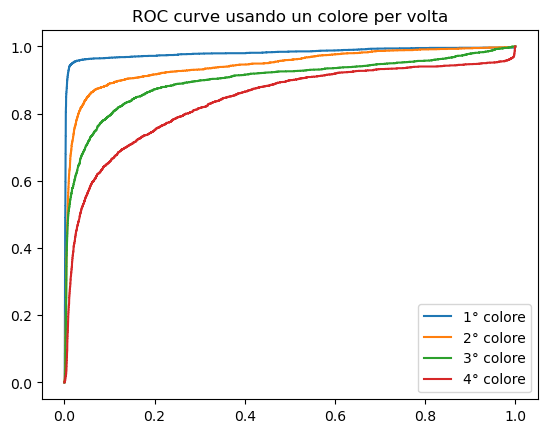

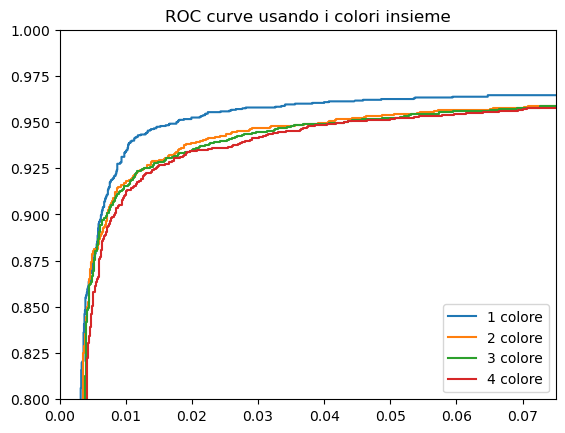

In [10]:
#GAUSSIAN NAIVE BAYES

col_train, col_test, y_train, y_test = train_test_split(colori,labels, train_size=0.67, random_state=42)

gnb=GaussianNB()

for i in range(4):
    
    gnb.fit(col_train[:,i][:, np.newaxis], y_train)
    
    y_prob = gnb.predict_proba(col_test[:,i][:, np.newaxis])[:, 1]  
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    
    plt.plot(fpr, tpr, label=str(i+1)+str("° colore"))
plt.title("ROC curve usando un colore per volta")
plt.legend()
plt.show()


for i in range(4):
    
    gnb.fit(col_train[:,0:i+1], y_train)
    
    y_prob = gnb.predict_proba(col_test[:,0:i+1])[:, 1]  
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    
    plt.plot(fpr, tpr, label=str(i+1)+str(" colore"))
plt.title("ROC curve usando i colori insieme")
plt.legend()
plt.xlim(0, 0.075)
plt.ylim(0.8 ,1)
plt.show()
# miglior classifier è quello che corrisponde alla 1° colonna che è il colore u-g (come avevo supposto guardando corner)

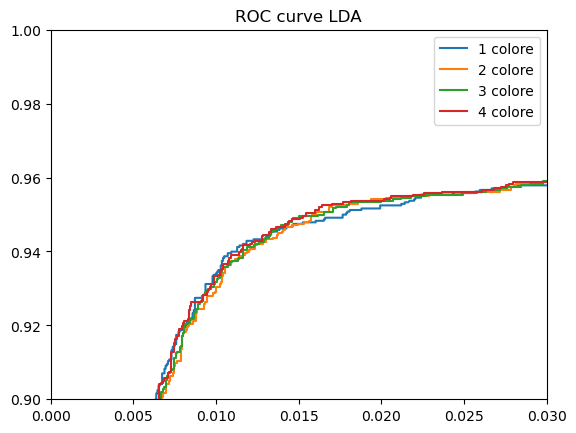

In [11]:
lda=LDA()

for i in range(4):
    
    lda.fit(col_train[:,0:i+1], y_train)
    
    y_prob = lda.predict_proba(col_test[:,0:i+1])[:, 1]  
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    
    plt.plot(fpr, tpr, label=str(i+1)+str(" colore"))
plt.legend()
plt.title("ROC curve LDA")
plt.xlim(0, 0.03)
plt.ylim(0.9 ,1)
plt.show()

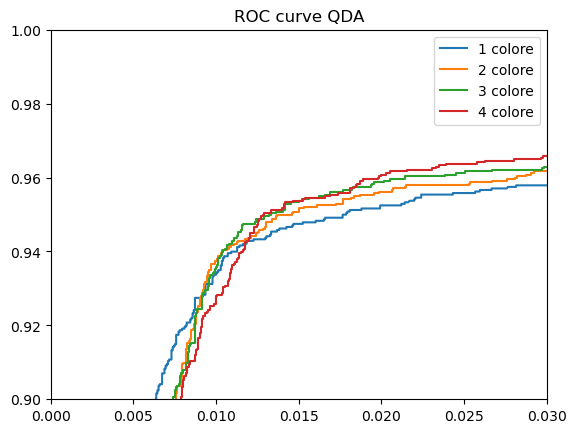

In [12]:
qda=QDA()

for i in range(4):

    qda.fit(col_train[:,0:i+1] ,y_train )
    y_prob = qda.predict_proba(col_test[:,0:i+1])[:,1] 
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=str(i+1)+str(" colore"))
    
plt.legend()
plt.title("ROC curve QDA")
plt.xlim(0, 0.03)
plt.ylim(0.9 ,1)
plt.show()

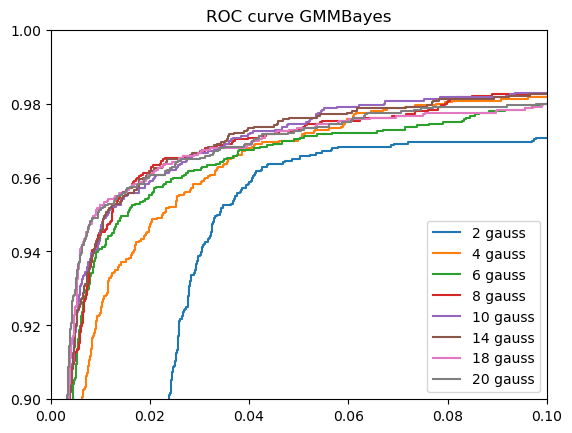

In [13]:
from astroML.classification import GMMBayes

N=[2,4,6,8,10,14,18,20]
for n in (N):
    
    gnb=GMMBayes(n_components=n)
    
    gnb.fit(col_train[:,0:4], y_train)
    
    y_prob = gnb.predict_proba(col_test[:,0:4])[:, 1]  
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    
    plt.plot(fpr, tpr, label=str(n)+str(" gauss"))
plt.title("ROC curve GMMBayes")
plt.legend()
plt.xlim(0,0.1)
plt.ylim(0.9,1)
plt.show()

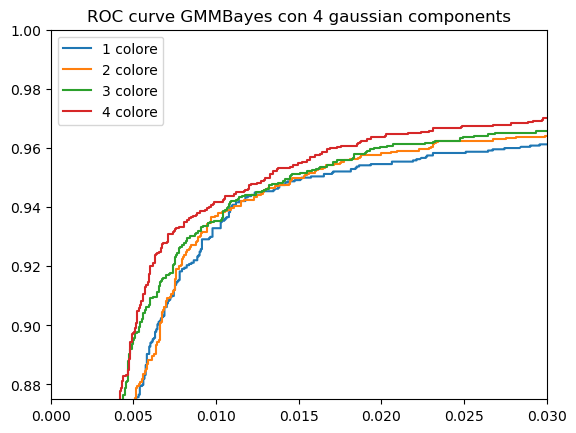

In [14]:
#num gaussiane scelto dal ROC curve
gmmb=GMMBayes(4)

for i in range(4):
    gmmb.fit(col_train[:,0:i+1], y_train)
    y_pred=gmmb.predict(col_test[:,0:i+1])
    y_prob = gmmb.predict_proba(col_test[:,0:i+1])[:, 1]  
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    
    plt.plot(fpr, tpr, label=str(i+1)+str(" colore"))
plt.title("ROC curve GMMBayes con 4 gaussian components")
plt.xlim(0, 0.03)
plt.ylim(0.875 ,1)
plt.legend()
plt.show()

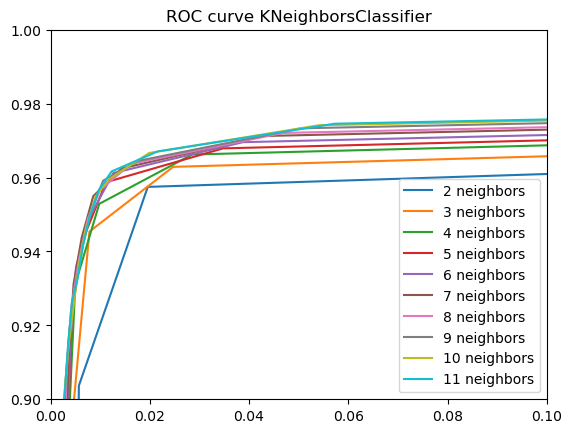

In [16]:
from sklearn.neighbors import KNeighborsClassifier
N=np.arange(2,12)
for n in (N):
    knb= KNeighborsClassifier(n)
    
    knb.fit(col_train[:,0:4], y_train)
    
    y_prob = knb.predict_proba(col_test[:,0:4])[:, 1]  
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    
    plt.plot(fpr, tpr, label=str(n)+str(" neighbors"))
plt.title("ROC curve KNeighborsClassifier")
plt.legend()
plt.xlim(0,0.1)
plt.ylim(0.9,1)
plt.show()

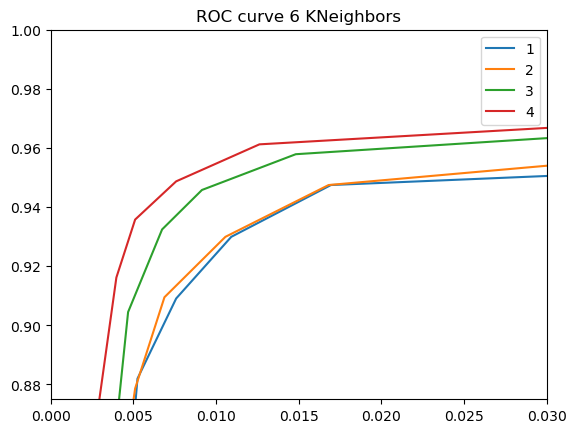

In [17]:
knb= KNeighborsClassifier(6)

for i in range(4):
    
    knb.fit(col_train[:,0:i+1], y_train)
    y_pred=knb.predict(col_test[:,0:i+1])
    y_prob = knb.predict_proba(col_test[:,0:i+1])[:, 1]  
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    
    plt.plot(fpr, tpr, label=str(i+1))
plt.xlim(0, 0.03)
plt.ylim(0.875 ,1)
plt.title("ROC curve 6 KNeighbors")
plt.legend()
plt.show()

In [18]:
gmmb=GMMBayes(4)  

gmmb.fit(col_train[:, 0:4], y_train)

y_pred=gmmb.predict(col_test[0:, 0:4])

completeness 0.9286905754795663
contamination 0.05153321976149915


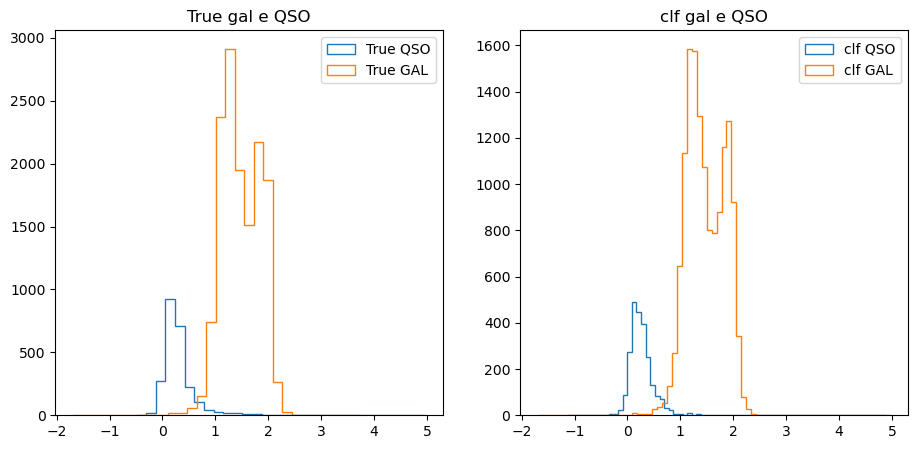

In [19]:
completeness, contamination = completeness_contamination(y_pred, y_test)

print("completeness", completeness)
print("contamination", contamination)

QSOtrue=col_test[:, 0:1][y_test==1] 
QSOclf=col_test[:, 0:1][y_pred==1]

GALtrue=col_test[:, 0:1][y_test==0]
GALclf=col_test[:, 0:1][y_pred==0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))

# Primo plot
ax1.hist(QSOtrue, bins=30, histtype='step', label="True QSO")
ax1.hist(GALtrue, bins=30, histtype='step', label="True GAL")
ax1.legend()
ax1.set_title("True gal e QSO")

# Secondo plot
ax2.hist(QSOclf, bins=70, histtype='step', label="clf QSO")
ax2.hist(GALclf, bins=70, histtype='step', label="clf GAL")

ax2.legend()
ax2.set_title("clf gal e QSO")

plt.show()


In [44]:
#provo a fare dimensionality reduction per vedere se riesco a classificarli meglio (anche se ottengo già un buon risultato)
from sklearn.decomposition import PCA

pca = PCA(n_components=2) 
pca.fit(colori) 

col_reduced = pca.transform(colori)
evals = pca.explained_variance_ratio_
print(evals)

[0.75887541 0.13734348]


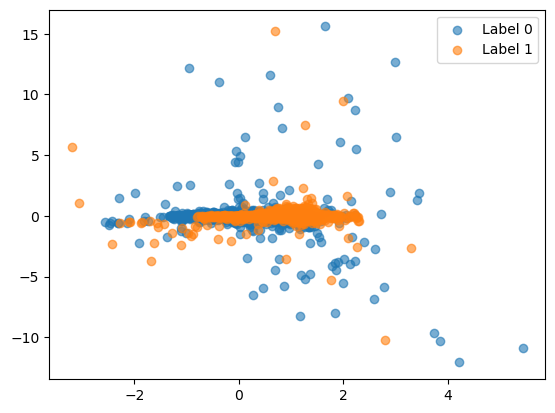

In [45]:
for label in np.unique(labels):
    plt.scatter(col_reduced[:,0][labels == label], col_reduced[:,1][labels == label], label=f'Label {label}', alpha=0.6)
plt.legend()
plt.show()
#PCA non riesce a dividere bene

In [46]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2,learning_rate=200)
X_reduced = tsne.fit_transform(colori)

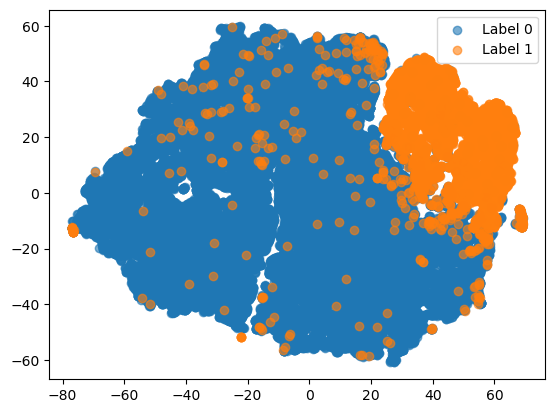

In [47]:
for label in np.unique(labels):
    plt.scatter(X_reduced[:,0][labels == label], X_reduced[:,1][labels == label], label=f'Label {label}', alpha=0.6)
plt.legend()
plt.show()


In [48]:
#faccio classification con i dati ridotti 
x_train, x_test, y_train, y_test = train_test_split(X_reduced,labels, train_size=0.67, random_state=42)

gmmb=GMMBayes(4)

gmmb.fit(x_train[:, 0:4], y_train)

y_pred=gmmb.predict(x_test[0:, 0:4])

completeness 0.9149291075896581
contamination 0.037719298245614034


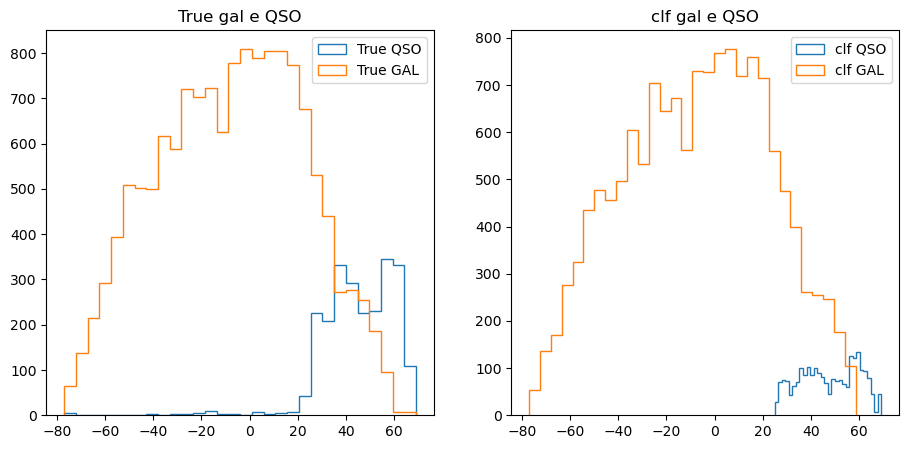

In [49]:
completeness, contamination = completeness_contamination(y_pred, y_test)

print("completeness", completeness)
print("contamination", contamination)

QSOtrue=x_test[:, 0:1][y_test==1]
QSOclf=x_test[:, 0:1][y_pred==1]

GALtrue=x_test[:, 0:1][y_test==0]
GALclf=x_test[:, 0:1][y_pred==0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))

# Primo plot
ax1.hist(QSOtrue, bins=30, histtype='step', label="True QSO")
ax1.hist(GALtrue, bins=30, histtype='step', label="True GAL")
ax1.legend()
ax1.set_title("True gal e QSO")

# Secondo plot
ax2.hist(QSOclf, bins=30, histtype='step', label="clf QSO")
ax2.hist(GALclf, bins=30, histtype='step', label="clf GAL")

ax2.legend()
ax2.set_title("clf gal e QSO")

plt.show()

dimensionality reduction non migliora